In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from config.settings import *

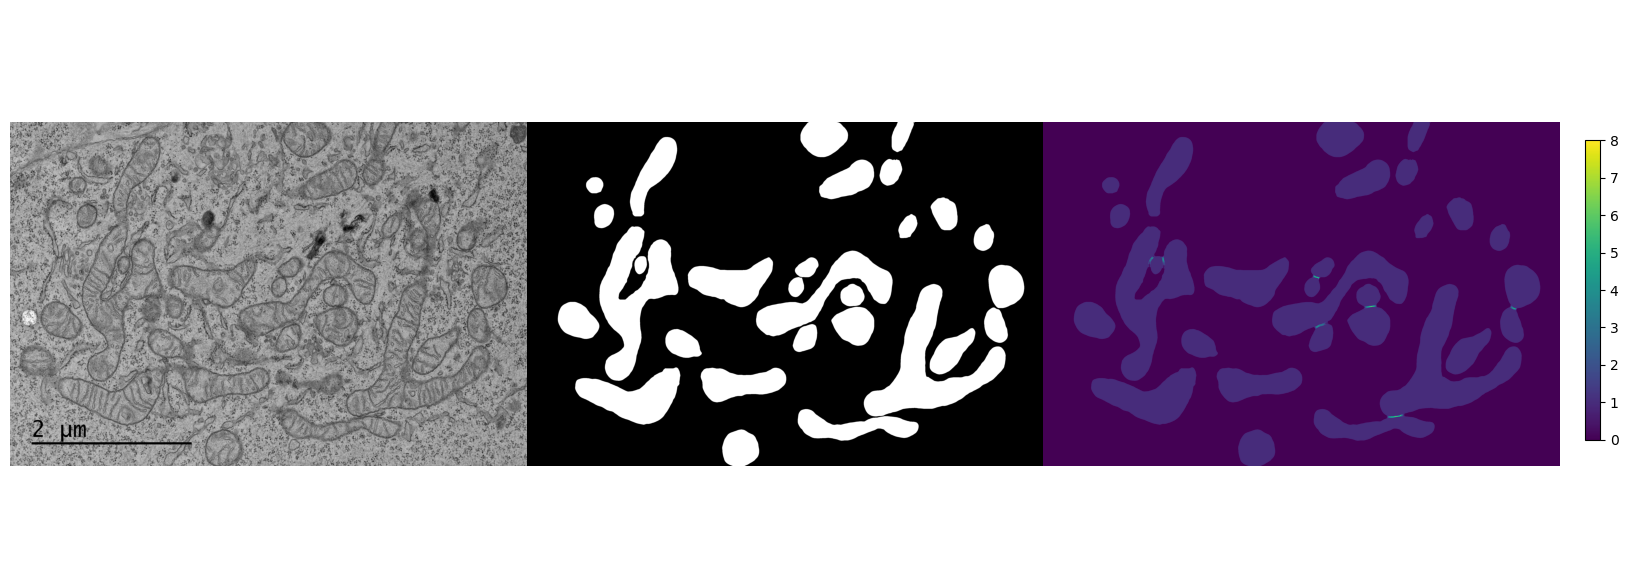

In [11]:
import matplotlib.pyplot as plt
from src.data.loaders import MitoSemsegDataset

dataset = MitoSemsegDataset(root=TRAIN_ROOT, weights=True)
img, mask, weight = dataset[81]

fig, ax = plt.subplots(1, 3, figsize=(20,8))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(mask, cmap='gray')
w = ax[2].imshow(weight+mask)
cbar_ax = fig.add_axes([0.87, 0.15, 0.05, 0.7])

[a.axis('off') for a in fig.axes]
fig.colorbar(w, ax=cbar_ax);
plt.subplots_adjust(wspace=0)

In [3]:
from src.data.loaders import get_mean_and_std
mean, std = get_mean_and_std()
mean, std

(0.6551765203475952, 0.15311938524246216)

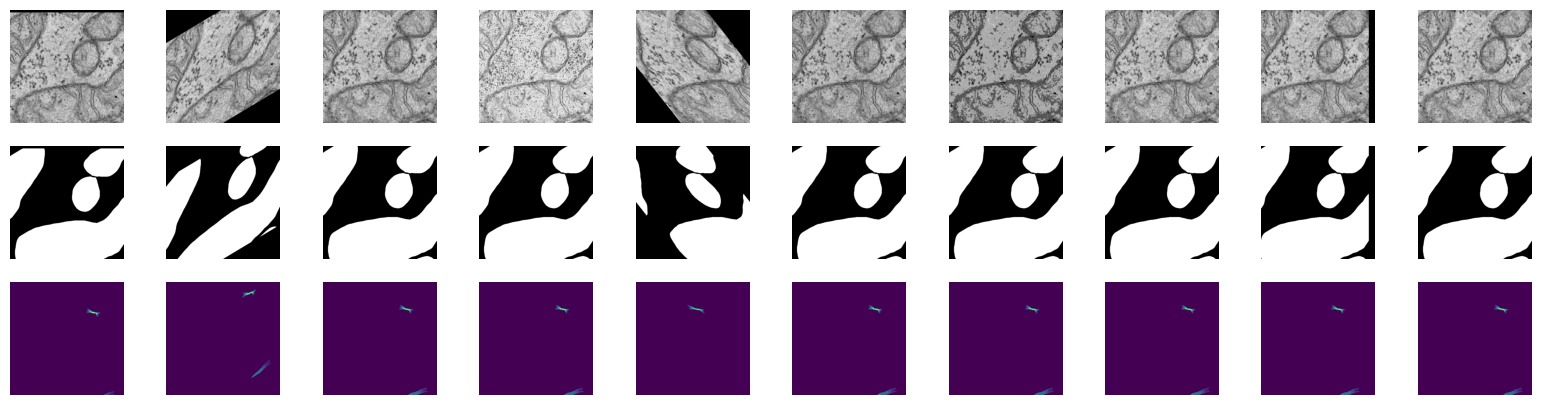

In [6]:
import torchvision.transforms.v2 as T
from src.data.loaders import TrivialAugmentWide

transforms = T.Compose([T.CenterCrop(500), TrivialAugmentWide(), T.ConvertDtype(), T.Normalize(mean=[0.6552], std=[0.1531])])

dataset = MitoSemsegDataset(root=TRAIN_ROOT, transforms=transforms, weights=True)

top, left, h, w = 1100, 3500, 400, 400

m, n = 3, 10
augs = [dataset[81] for _ in range(n)]

fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(m, n, wspace=.1)
ax = gs.subplots()
[a.axis('off') for a in fig.axes]
for i in range(n):
    ax[0,i].imshow(augs[i][0].squeeze(), cmap='gray')
    ax[1,i].imshow(augs[i][1], cmap='gray')
    ax[2,i].imshow(augs[i][2])

### Elastic warp test
"Especially random elastic deformations of the training samples seem to be the key concept to train a segmentation network with very few annotated images." <br>
Using torchvision's ElasticTransform, 0-1500 seems to be a nice range for magnitude (alpha) and 30 a nice value for smoothness (sigma)

In [7]:
import cv2 as cv
import numpy as np
import torchvision.transforms.v2 as T
import time
import ipywidgets

def draw_grid(src, grid_shape, color=0, thickness=1):
    h, w, *_ = src.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(src, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(src, (0, y), (w, y), color=color, thickness=thickness)

    return src

@ipywidgets.interact(alpha=(0.,2000.0,10.),sigma=(0.,100.,1.))
def warp(alpha=1500.,sigma=30.0):
    dataset = MitoSemsegDataset(root=TRAIN_ROOT)
    img, mask = dataset[81]

    top, left, h, w = 1100, 2500, 1000, 1000
    crop = img[top:top+h,left:left+w]

    draw_grid(crop,(10,10))
    tf = T.Compose([T.ToTensor(), T.ElasticTransform(alpha,sigma)])
    t = time.time()
    warped = tf(crop)
    print(time.time()-t)

    plt.imshow(warped.squeeze(),cmap='gray')

interactive(children=(FloatSlider(value=1500.0, description='alpha', max=2000.0, step=10.0), FloatSlider(value…